In [1]:
import torch
import torch.nn as nn
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collate_fn, plot_mri_slice, plot_all_slices, plot_all_slices_from_array

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
ds = Dataset()

In [4]:
cases = ds.load_raw_mri()
masks = ds.load_cmb_masks()

transform = NiftiToTensorTransform(target_shape = (50, 50), rpn_mode=True)

In [5]:
dataset = VALDODataset(
    cases=cases,
    masks=masks,
    transform=transform,
    normalization=z_score_normalization,
)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [6]:
dloader = DataLoader(
    dataset,
    shuffle=True,
    batch_size=1,
    collate_fn=collate_fn,
)

In [7]:
from project.model import RPN

config = {
    'model': RPN(50**2, 4, 5, 2500).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 10,
    'loss': nn.SmoothL1Loss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.00001
}

C:\Program Files\Python310\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
from project import Fitter

class RPNFitter(Fitter):
    def train_one_epoch(self, train_loader):
        self.model.train()
        # for all samples in train_loader
        loss_history = []
        for slices, masks, case, counts in train_loader:
            num_slices = slices.shape[0]
            masks = masks.view(num_slices, 1, -1).float().to(self.device)
            # x = slices.view(num_slices, 1, 1, -1).float().to(self.device)
            x = slices.view(num_slices, 1, -1).float().to(self.device)
            y = []
            # feed each slice to rpn
            y = self.model(x)
            # for slc in x:
                # out = self.model(slc)
                # y.append(out)
                
            # y = torch.stack(y)
            # calculate loss
            losses = self.loss(y, masks)
            loss_history.append(losses)
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
        
        return loss_history
        # requery rpn with 
        
    def validation(self, val_loader):
        self.model.eval()
        with torch.inference_mode():
            loss_history = []
            # feed all samples
            for slices, masks, case, counts in val_loader:
                num_slices = slices.shape[0]
                masks = masks.float().to(self.device)
                x = slices.view(num_slices, 1, 1, -1).float().to(self.device)
                y = []
                for slc in x:
                    out = self.model(slc)
                    y.append(out)
                y = torch.stack(y)
                # calculate loss
                losses = self.loss(y, masks)
                loss_history.append(losses)
            
            return loss_history
            # get prediction per slice

In [9]:
fitter = RPNFitter(config)

In [ ]:
hist = fitter.fit(dloader, dloader)

In [13]:
torch.tensor(hist[9])

tensor([1.3848e-04, 3.8609e+00, 1.9006e-03, 5.1671e-01, 5.8822e-01, 3.2237e-04,
        1.6168e+00, 1.2933e+00, 2.1389e+00, 8.6369e+00, 8.4274e-04, 1.0897e-03,
        6.6496e+00, 7.0392e-01, 9.2441e+00, 1.4778e-03, 7.2088e-01, 1.1944e-03,
        1.0247e+01, 4.6232e-01, 6.0563e-01, 4.8226e-01, 1.1602e+00, 1.6197e+00,
        1.2565e+00, 4.9704e+00, 6.1418e-01, 8.7597e-04, 1.3519e+00, 9.2944e+00,
        1.1526e-02, 1.0225e+00, 3.8889e+00, 8.9074e-01, 1.9797e+00, 3.6714e+00,
        4.9179e-01, 1.3902e+01, 1.6950e-02, 4.9832e-01, 1.0553e+00, 4.4621e+00,
        1.2307e+00, 5.8854e-02, 4.2977e+00, 9.0579e-03, 5.1234e-01, 6.2934e-01,
        1.9560e-02, 4.8756e-01, 6.3389e-01, 2.9441e-01, 2.7595e-03, 1.2949e+00,
        4.9817e-03, 1.2795e-02, 5.5837e-01, 1.7090e-03, 2.3174e-04, 4.2558e-02,
        1.1246e+00, 6.4104e-01, 1.6884e+00, 6.6596e-01, 8.0140e-05, 1.0382e+00,
        1.1680e+00, 1.9955e-04, 9.4002e-04, 4.7169e-01, 4.7612e-01, 8.0234e-01])

<Axes: >

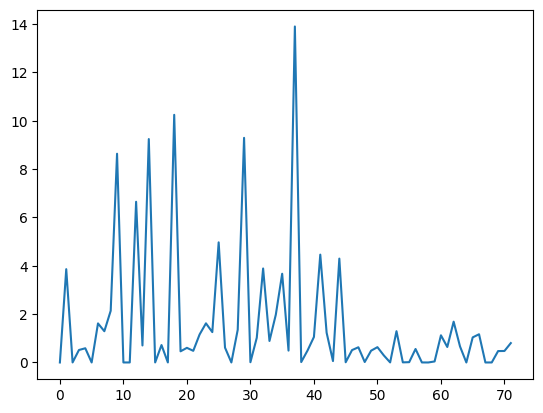

In [16]:
import seaborn as sns

sns.lineplot(torch.tensor(hist[9]))